In [1]:
import numpy as np
import torch
import torch.cuda
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration,AutoModelForMaskedLM

/home2/autotune_vits/miniconda3/envs/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 2080 Ti


In [3]:
def read_csv_file_input(file_path):
    data = []
    with open(file_path, 'r',encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if len(row['input']) < 100 :
                data.append(row['input'])
            if len(data) >= 100000:
                break
    return data

def read_csv_file_output(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Check if 'output' is not NULL (not an empty string or None)
            if row['output'] and len(row['output']) < 100:
                data.append(row['output'])
            if len(data) >= 100000:
                break
    return data

def evaluate_perplexity(curr_sentence,rb_model,Tokenizer):

    encoded_sentence = Tokenizer.encode(curr_sentence,return_tensors = 'pt').to(device)

    dim = encoded_sentence.size(-1) - 1 # removing start and end
    final_encoded = encoded_sentence.repeat(dim-1,1).to(device)


    mask_tensor = torch.ones(dim).to(device)

    mask_tensor = mask_tensor.diag(1)[:-2]

    mask_tensor = final_encoded.masked_fill(mask_tensor == 1,Tokenizer.mask_token_id)

    labels = final_encoded.masked_fill(mask_tensor != Tokenizer.mask_token_id,-100)

    with torch.no_grad():
        outputs = rb_model(input_ids=mask_tensor, labels=labels)
        loss = outputs.loss

    # Calculate and return perplexity
    perplexity = np.exp(loss.item())
    return perplexity


In [ ]:
Model_name = 'roberta-base'

#using a pre-trained tokenizer
Tokenizer = AutoTokenizer.from_pretrained(Model_name)

rb_model =  AutoModelForMaskedLM.from_pretrained(Model_name).to(device)

file_path = './C4_200M_1M.csv'
data = read_csv_file_input(file_path)
print(len(data))

In [ ]:
results = []

for i in tqdm(range(0, len(data)), desc="Progress Bar"):
    perp = evaluate_perplexity(curr_sentence=data[i], rb_model=rb_model, Tokenizer=Tokenizer)

    results.append(perp)

results = np.array(results)

print("Mean Perplexity Input:", np.mean(results))
print("Median Perplexity Input:", np.median(results))

In [ ]:
# Plot histogram of perplexity scores
plt.hist(results, bins=250, log=True)
plt.xlabel("Perplexity")
plt.ylabel("Frequency (log scale)")
plt.savefig("Transformer-input-wrong.png")
plt.show()

In [4]:
Model_name = 'roberta-base'

#using a pre-trained tokenizer
Tokenizer = AutoTokenizer.from_pretrained(Model_name)

rb_model =  AutoModelForMaskedLM.from_pretrained(Model_name).to(device)

file_path = './C4_200M_1M.csv'
data = read_csv_file_output(file_path)
print(len(data))

100000


In [5]:
results = []

for i in tqdm(range(0, len(data)), desc="Progress Bar"):
    perp = evaluate_perplexity(curr_sentence=data[i], rb_model=rb_model, Tokenizer=Tokenizer)

    results.append(perp)

results = np.array(results)

print("Mean Perplexity Output:", np.mean(results))
print("Median Perplexity Output:", np.median(results))

Progress Bar: 100%|██████████| 100000/100000 [22:07<00:00, 75.33it/s]

Mean Perplexity Output: 102.45619526111389
Median Perplexity Output: 10.108536263758932


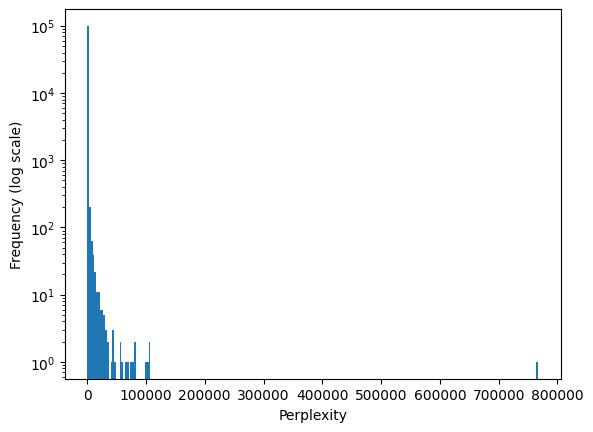

In [6]:
# Plot histogram of perplexity scores
plt.hist(results, bins=250, log=True)
plt.xlabel("Perplexity")
plt.ylabel("Frequency (log scale)")
plt.savefig("Transformer-output-correct.png")
plt.show()